![snap](https://lever-client-logos.s3.amazonaws.com/2bd4cdf9-37f2-497f-9096-c2793296a75f-1568844229943.png)

# Machine Learning

## Librairies & Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import joblib
import os

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
df_pricing = pd.read_csv(
    "https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_pricing_project.csv", index_col=0, low_memory=False)
print(
    f"Observations : {df_pricing.shape[0]}\n\nFeatures : {df_pricing.shape[1]}")
display(df_pricing.head())
display(df_pricing.describe())


Observations : 4843

Features : 14


,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


,mileage,engine_power,rental_price_per_day
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,121.214536
std,6.019674e+04,38.99336,33.568268
min,-6.400000e+01,0.00000,10.000000
25%,1.029135e+05,100.00000,104.000000
50%,1.410800e+05,120.00000,119.000000
75%,1.751955e+05,135.00000,136.000000
max,1.000376e+06,423.00000,422.000000


## Are there any missing values?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4843 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   model_key                  4843 non-null   object
 1   mileage                    4843 non-null   int64 
 2   engine_power               4843 non-null   int64 
 3   fuel                       4843 non-null   object
 4   paint_color                4843 non-null   object
 5   car_type                   4843 non-null   object
 6   private_parking_available  4843 non-null   bool  
 7   has_gps                    4843 non-null   bool  
 8   has_air_conditioning       4843 non-null   bool  
 9   automatic_car              4843 non-null   bool  
 10  has_getaround_connect      4843 non-null   bool  
 11  has_speed_regulator        4843 non-null   bool  
 12  winter_tires               4843 non-null   bool  
 13  rental_price_per_day       4843 non-null   int64 
dtypes: bool(

None

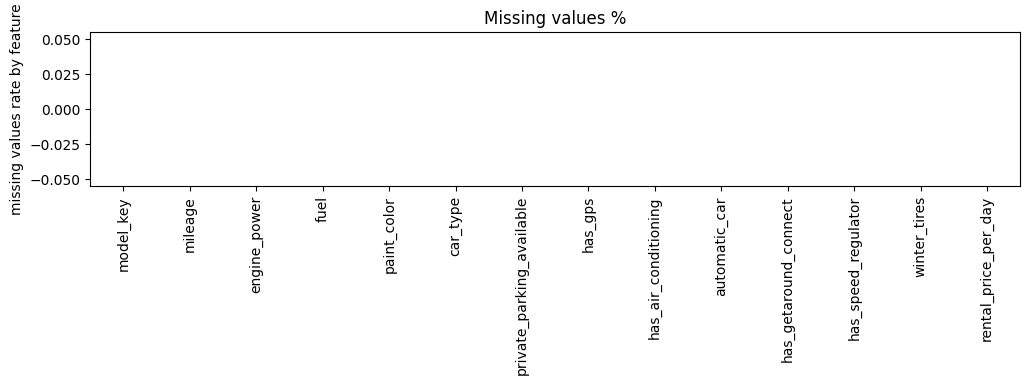

In [3]:
display(df_pricing.info())
(df_pricing.isna().mean().sort_values()*100).plot(
    kind="bar", figsize=(12, 2),
    title="Missing values %",
    ylabel="missing values rate by feature")
plt.show()


In [4]:
# df.corr() function works for numeric columns. So non numerical columns will be encoded
for col in df_pricing.columns:
    dtypes_fact = [object, bool]
    if df_pricing[col].dtype in dtypes_fact:
        df_pricing.loc[:, 'Encoded_'+col] = pd.factorize(df_pricing[col])[0]

print('\nTop features corresponded to rental price per day\n')
## abs() is important cause we want positive and negative correlation
corr_match = df_pricing.corr(numeric_only=True).loc[:, ['rental_price_per_day']].abs().sort_values(by='rental_price_per_day', ascending=False) 
corr_match.head(20)



Top features corresponded to rental price per day



,rental_price_per_day
rental_price_per_day,1.000000
engine_power,0.625645
mileage,0.448912
automatic_car,0.419761
Encoded_automatic_car,0.419761
Encoded_model_key,0.362168
Encoded_has_getaround_connect,0.318486
has_getaround_connect,0.318486
has_gps,0.310889
Encoded_has_gps,0.310889


Correspondance matrix 



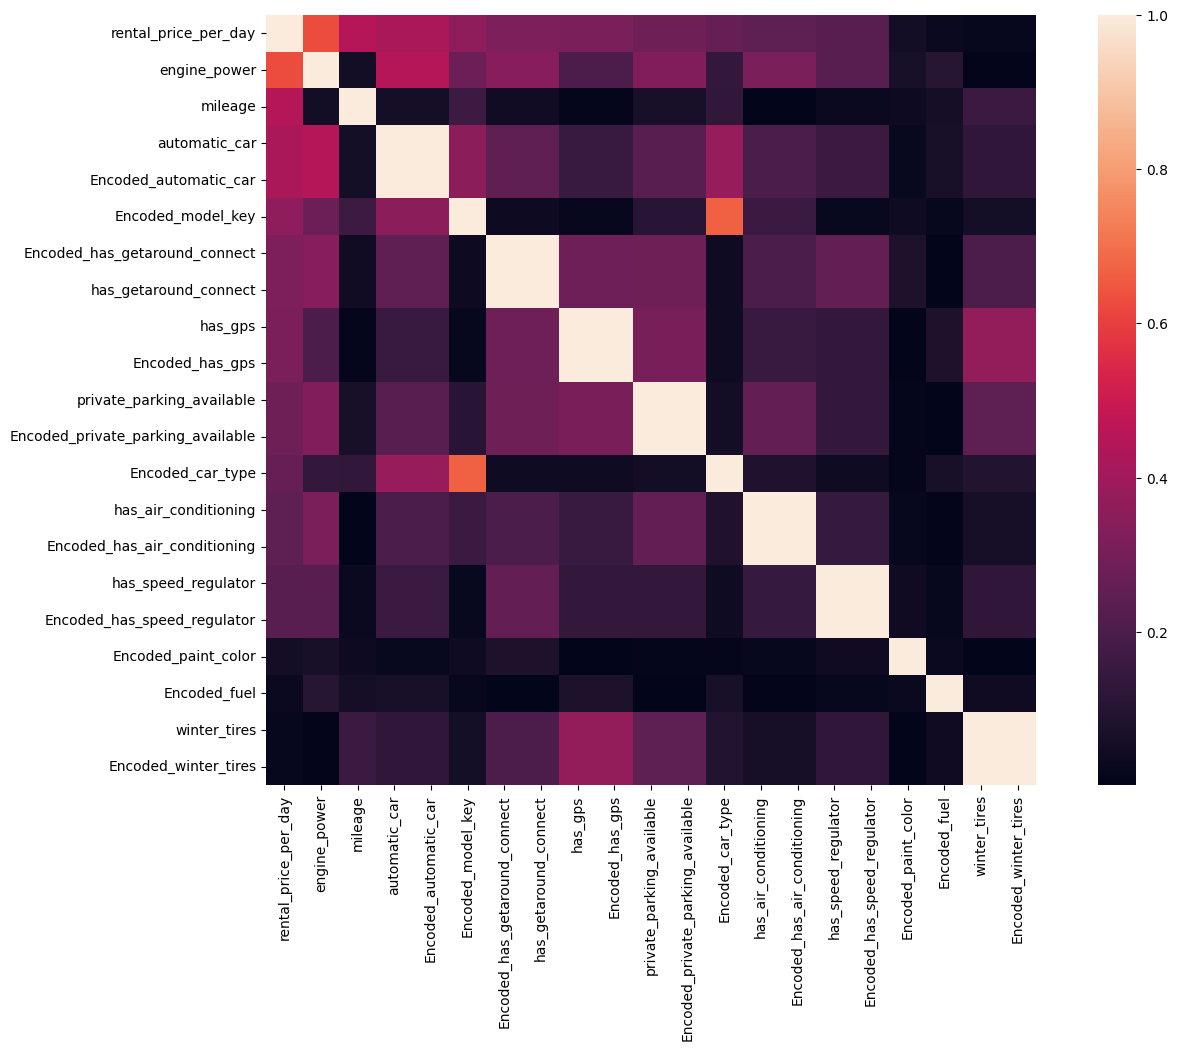

In [5]:
print("Correspondance matrix \n")
key_cols = corr_match.index
f, ax = plt.subplots(figsize=(16, 10))
sb.heatmap(df_pricing[key_cols].corr().abs(), square=True, annot=False) # set annot to True to see values
plt.show()

# Preprocessing Pipeline

**Target**
- rental_price_per_day
  
**Features**
- very well correlated: engine_power, automatic_car, mileage

- well correlated: model_key_, has_getaround_connect, has_gps, car_type, private_parking_available, has_air_conditioning, has_speed_regulator

- slightly correlated: paint_color_, fuel_, winter_tires

In [6]:
features = [
    "Encoded_model_key",
    "mileage",
    "engine_power",
    "Encoded_fuel",
    "Encoded_paint_color", 
    "Encoded_car_type",
    "Encoded_private_parking_available", 
    "Encoded_has_gps",
    "Encoded_has_air_conditioning", 
    "Encoded_automatic_car",
    "Encoded_has_getaround_connect", 
    "Encoded_has_speed_regulator",
    "Encoded_winter_tires"
    ]
target = 'rental_price_per_day'

X = df_pricing.loc[:,features]
Y = df_pricing.loc[:,target]

# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('\nFound numeric features ', numeric_features)
print('\nFound categorical features ', categorical_features)


Found numeric features  ['Encoded_model_key', 'mileage', 'engine_power', 'Encoded_fuel', 'Encoded_paint_color', 'Encoded_car_type', 'Encoded_private_parking_available', 'Encoded_has_gps', 'Encoded_has_air_conditioning', 'Encoded_automatic_car', 'Encoded_has_getaround_connect', 'Encoded_has_speed_regulator', 'Encoded_winter_tires']

Found categorical features  []


In [7]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=0)

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

## Metric and evalutation process

We use the root mean squared error (RMSE) to assess the performance of the models since we try to predict rental price per day, it used to use this metrics with same scale prices

We use the cross_val_score function of sklearn to evaluate a score by cross-validation.

Then, we use the function Kfold to shuffle attribution as cross_val_score does not have this option.

## XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [9]:
# Perform grid search
print("Grid search...")
xgb_estimator = xgb.XGBRegressor()

# Grid of values to be tested
params = {
    'max_depth': [8, 10, 12],
    'learning_rate': [0.03, 0.04, 0.05],
    'n_estimators': [180, 185, 190, 250],
    'colsample_bytree': [0.7, 0.75, 0.8, 0.9],
    'subsample': [0.8],
}

# cv : the number of folds to be used for CV
gridsearch = GridSearchCV(xgb_estimator, param_grid=params, cv=5)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)


Grid search...
...Done.
Best hyperparameters :  {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 12, 'n_estimators': 250, 'subsample': 0.8}
Best validation accuracy :  0.7610708247445659


In [10]:
# Perform grid search
print("Grid search...")
regressor = xgb.XGBRegressor()

# Grid of values to be tested

params = {
    'max_depth': [4, 8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 250],
    'colsample_bytree': [0.9],
    'subsample': [0.8],
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 4) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.8}
Best validation accuracy :  0.744578993394168


In [11]:
# create model
xgb_model = xgb.XGBRegressor(
    max_depth=gridsearch.best_params_["max_depth"],
    learning_rate=gridsearch.best_params_["learning_rate"],
    n_estimators=gridsearch.best_params_["n_estimators"],
    colsample_bytree=gridsearch.best_params_["colsample_bytree"],
    subsample=gridsearch.best_params_["subsample"],
    random_state=0
)


# fit the model with the full train set and predict values for full train an test sets
xgb_model.fit(X_train, Y_train)
Y_train_pred = xgb_model.predict(X_train)
Y_test_pred = xgb_model.predict(X_test)


# score full train set
xgb_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', round(xgb_rmse_train, 2))

# score test set
xgb_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', round(xgb_rmse_test, 2))


train RMSE :  6.5
test RMSE :  15.56


Text(0.5, 0, 'XGBoost Feature Importance')

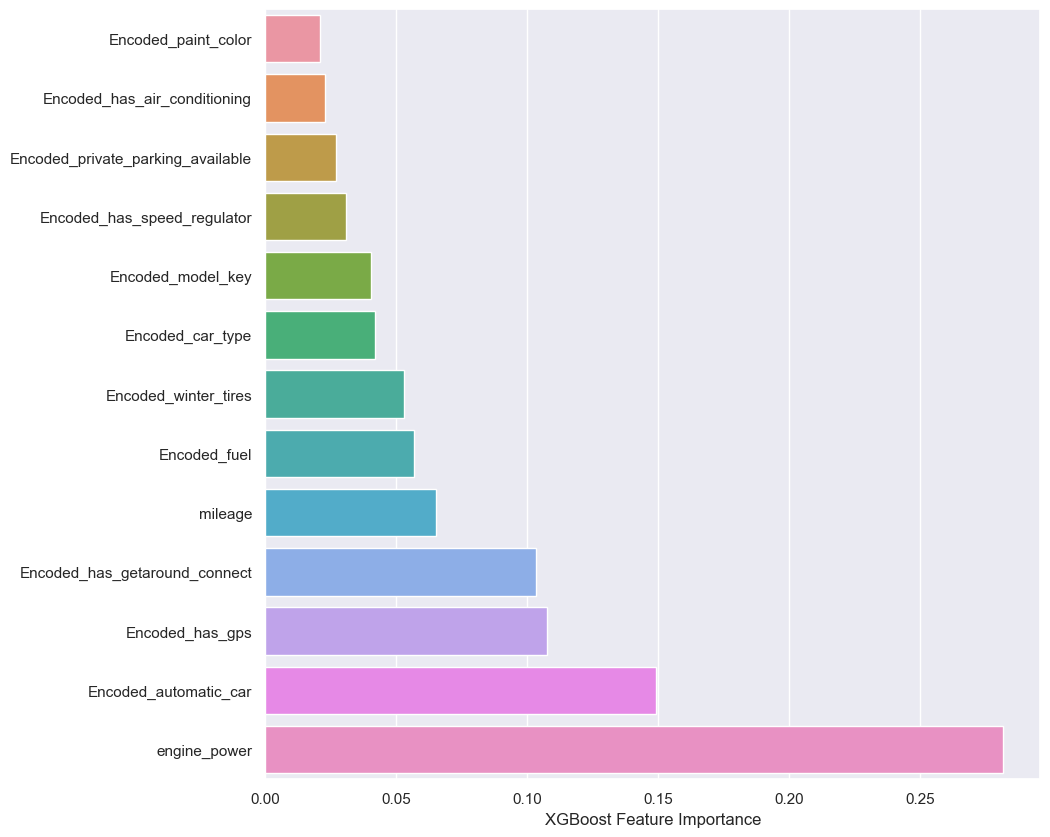

In [12]:
# plot feature importance
# The importance score is a measure of how often the feature was selected for splitting
# and how much gain in purity was achieved as a result of the selection
sorted_idx = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
sb.set()
sb.barplot(y = X.columns[sorted_idx], x = xgb_model.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")

5 features stand out :

- Engine power
- It's concern Automatic car or not
- car has chekin type connect or not
- The car has GPS or not
- mileage

# Random Forest

In [13]:
# Perform grid search
print("Grid search...")
random_forest_estimator = RandomForestRegressor()

# Grid of values to be tested
params = {
    'max_depth': [13, 14, 15],
    'min_samples_split': [1, 2, 4],
    'n_estimators': [370, 380, 390]
}

gridsearch = GridSearchCV(random_forest_estimator, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 380}
Best validation accuracy :  0.7283079192120834


In [14]:
# fit the model with the full train set and predict values for full train an test sets
# create model
random_forest_model = RandomForestRegressor(
    n_estimators=gridsearch.best_params_["n_estimators"],
    max_depth=gridsearch.best_params_["max_depth"],
    min_samples_split=gridsearch.best_params_["min_samples_split"],
    random_state=0
)

random_forest_model.fit(X_train, Y_train)
Y_train_pred = random_forest_model.predict(X_train)
Y_test_pred = random_forest_model.predict(X_test)

# score full train set
random_forest_rmse_train = mean_squared_error(
    Y_train, Y_train_pred, squared=False)
print('train RMSE : ', random_forest_rmse_train)

# score test set
random_forest_rmse_test = mean_squared_error(
    Y_test, Y_test_pred, squared=False)
print('test RMSE : ', random_forest_rmse_test)


train RMSE :  7.782950615822338
test RMSE :  15.80452499880927


Text(0.5, 0, 'Random forest feature importance')

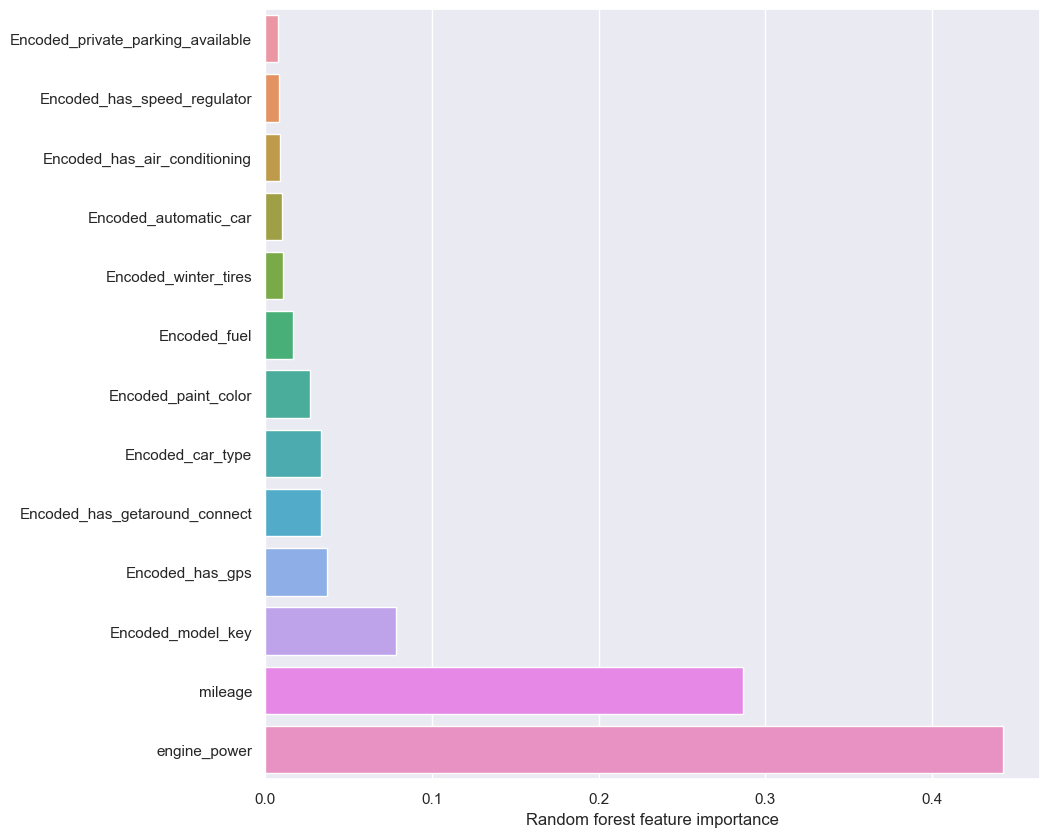

In [15]:
# plot feature importance
# The importance score is a measure of how often the feature was selected for splitting
# and how much gain in purity was achieved as a result of the selection
sorted_idx = random_forest_model.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
sb.barplot(y = X.columns[sorted_idx], x = random_forest_model.feature_importances_[sorted_idx])
plt.xlabel("Random forest feature importance")

3 features stand out :

- Engine power
- mileage
- model key


# Retained model

In [16]:
# Separate target variable Y from features X
print("Separating labels from features...")

features = [
    "model_key",
    "mileage",
    "engine_power",
    "fuel",
    "paint_color", 
    "car_type",
    "private_parking_available", 
    "has_gps",
    "has_air_conditioning", 
    "automatic_car",
    "has_getaround_connect", 
    "has_speed_regulator",
    "winter_tires"
    ]

target = "rental_price_per_day"

X = df_pricing.loc[:,features]
Y = df_pricing.loc[:,target]

# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('\nFound numeric features ', numeric_features)
print('\nFound categorical features ', categorical_features)

# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=4)

print("Preprocessing X_train...")
print()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print()

# Test pipeline
print("Preprocessing X_test...")
print()
X_test = preprocessor.transform(X_test)
print("...Done!")

# create model
xgb_model = xgb.XGBRegressor(
    max_depth=4,
    learning_rate=0.05,
    min_child_weight = 4,
    n_estimators=150,
    subsample=0.8,
    random_state=0
)

# fit the model with the full train set and predict values for full train an test sets
xgb_model.fit(X_train, Y_train)
Y_train_pred = xgb_model.predict(X_train)
Y_test_pred = xgb_model.predict(X_test)


# score full train set
xgb_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', round(xgb_rmse_train,2))

# score test set
xgb_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', round(xgb_rmse_test,2))

Separating labels from features...

Found numeric features  ['mileage', 'engine_power']

Found categorical features  ['model_key', 'fuel', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']
Preprocessing X_train...

...Done!

Preprocessing X_test...

...Done!
train RMSE :  14.58
test RMSE :  18.68


In [17]:
# dumping models
joblib.dump(preprocessor, "./api/preprocessor.joblib")
joblib.dump(xgb_model, "./api/model.joblib")

['./api/model.joblib']